# Number Plate Detection


In [1]:
!sudo apt-get install qt5-default

Reading package lists... Done
Building dependency tree       
Reading state information... Done
qt5-default is already the newest version (5.9.5+dfsg-0ubuntu2.6).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [2]:
import os
import sys
import numpy as np
import cv2

path_for_dataSet = os.path.join(os.getcwd(), 'ImageDataset')

images_array = os.listdir(path_for_dataSet)
if(not os.path.isdir('output')):
    os.mkdir('output')
path_for_output = os.path.join(os.getcwd(), 'Output')



In [3]:
# Image Reading
def image_read(imagePath):
    image = cv2.imread(imagePath)
    return image

In [4]:

# Original Image to Converting Grayscale
def convertImg2Grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:

# Removing Noise From image using Bilateral Filter
def remove_noise(img):
    return cv2.bilateralFilter(img, 10, 85, 85) # 9, 75, 75

In [6]:
# Equalizing Histogram for Image
def equalization_histogram(img):
    return cv2.equalizeHist(img)

In [7]:
# Using the provided structural element, morphologically opening the image
def morphological_opening(img, stct_element):
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, stct_element, iterations=16) # 15

In [8]:
# Remove the Histogram Equalized Image from the Morphologically Opened Image.
def remove_histogram_equalization(hist_equa_Img, morph_img):
    return cv2.subtract(hist_equa_Img, morph_img)

In [9]:
# Protecting the Image
def protect_Img(img):
    r, protectImage = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    return protectImage

In [10]:
# Canny - Edge - Detection
def edge_detection(image, portal1, portal2):
    cany_img = cv2.Canny(image, portal1, portal2)
    cany_img = cv2.convertScaleAbs(cany_img)
    return cany_img

In [11]:
# Edge-strengthening dilation
def image_Edge_Dilation(img, strct_element):
    return cv2.dilate(img, strct_element, iterations=1)

In [31]:
# Identifying the edges by locating the contours of the edge-dilated image

def finding_Contours(img):
    counter, image = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return counter

# The contours on the number plate should be smaller than other contours in order to solve this issue.
# So, we group the contours according to their area and select the ten lowest contours.

In [13]:

# Using the Ramer_Douglas_Peucker RDP algorithm, estimate the Polygon of the Contours.
#   Break when you get a quadrilateral
def approx_Contors(contors):
    approx_polygn = None
    for contor in contors:
        contor_perimtr = cv2.arcLength(contor, True)
        approx_polygn = cv2.approxPolyDP(contor, 0.05*contor_perimtr, closed=True) #0.06
        # Quadrilateral Found
        if(len(approx_polygn) == 4): 
            break
    return approx_polygn

In [14]:
# Create the approximate polygon in green on the image.
def create_Localized_NumberPlate(img, approx_polygn):
    moment =cv2.moments(approx_polygn)
    mX=int(moment['m10'] / moment['m00'])
    mY=int(moment['m01'] / moment['m00'])
    
    final_output_img = cv2.drawContours(img, [approx_polygn], -2, (1, 256, 1), 2) # -1 0 255 0 3
    
    cv2.circle(final_output_img, (mX, mY), 8, (1, 254, 1), -2)  # 7 0 255 0 -1
    cv2.putText(final_output_img, 'Plates center of gravity: ('+str(mX)+', '+str(mY)+')', (54,54), cv2.FONT_HERSHEY_SIMPLEX, 2, (1, 254, 1), 3) # 1 0 255 0 2
    
    return final_output_img


# work in progress

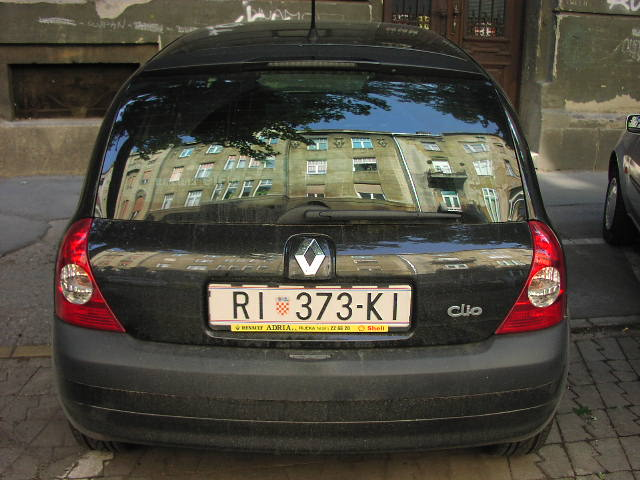

Grayscale Image


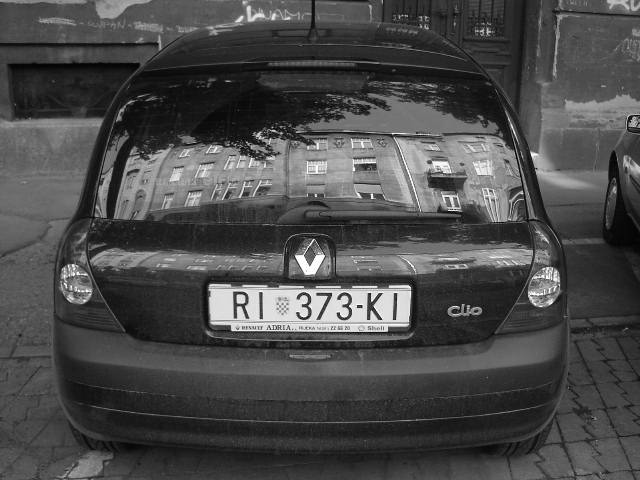

Noise Removed Image


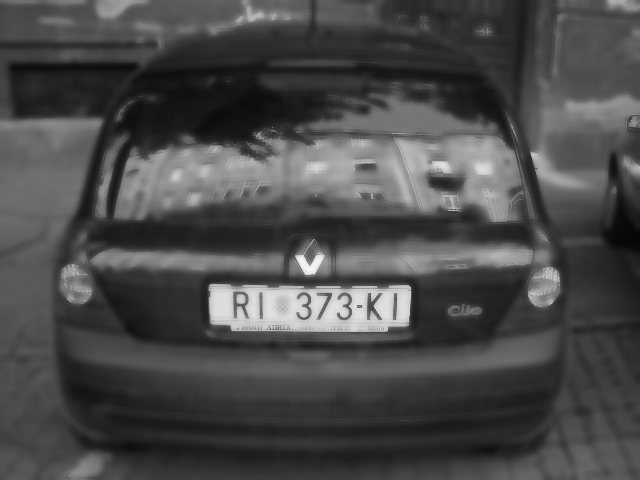

equalization_histogram


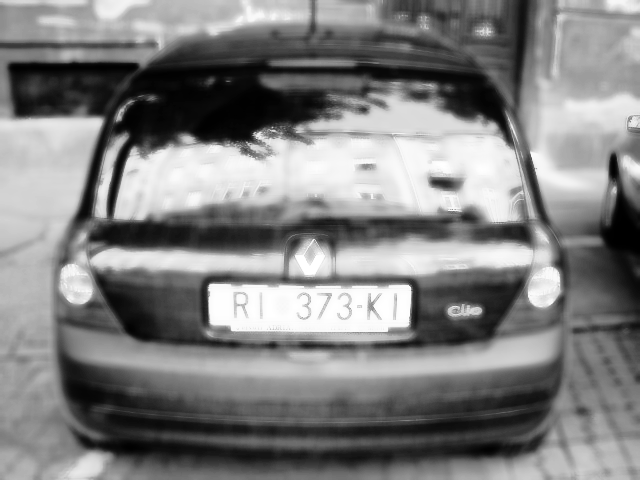

Dilated Edge Image


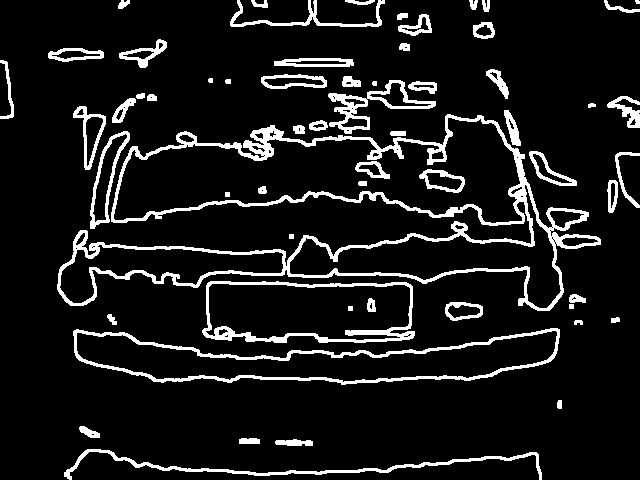

finalImage
[[[124 146 157]
  [123 145 156]
  [121 143 155]
  ...
  [ 87  87  99]
  [ 86  84  96]
  [ 87  84  99]]

 [[108 131 139]
  [110 133 141]
  [111 134 142]
  ...
  [ 77  79  90]
  [ 88  88 100]
  [105 105 119]]

 [[ 33  56  58]
  [ 39  62  64]
  [ 50  72  77]
  ...
  [ 79  81  91]
  [104 106 117]
  [137 139 150]]

 ...

 [[ 55  65  75]
  [ 54  64  74]
  [ 65  75  85]
  ...
  [ 73  84  92]
  [ 78  89  97]
  [ 73  84  92]]

 [[ 66  76  86]
  [ 68  78  88]
  [ 81  91 101]
  ...
  [ 70  81  89]
  [ 70  81  89]
  [ 72  83  91]]

 [[ 56  66  76]
  [ 58  68  78]
  [ 73  83  93]
  ...
  [ 68  79  87]
  [ 67  78  86]
  [ 76  87  95]]]
Opened Image


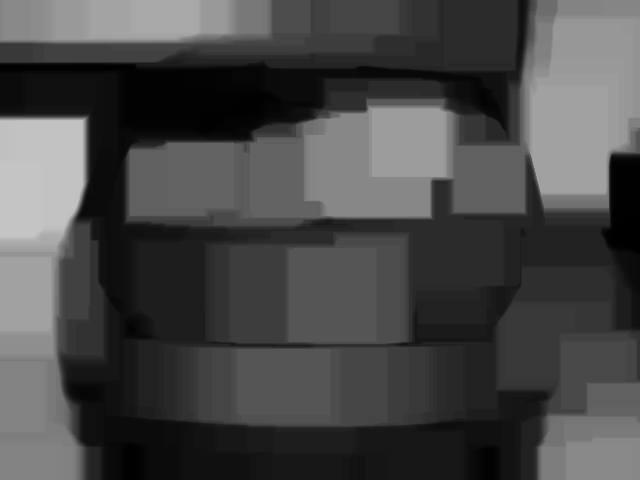

Subtracted Image


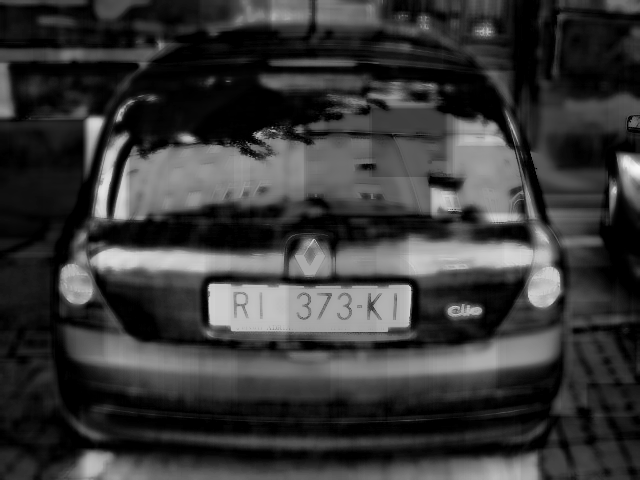

Thresholded Image


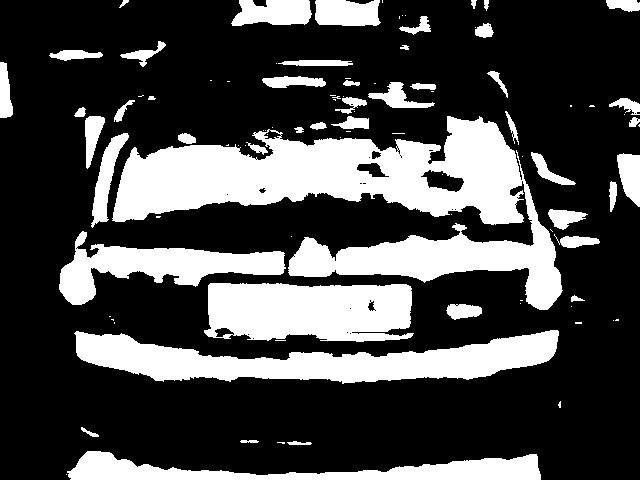

Edge Detected Image


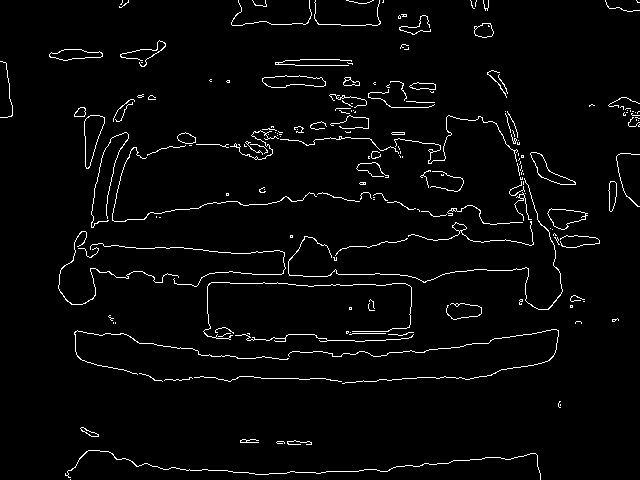

Dilated Edge Image


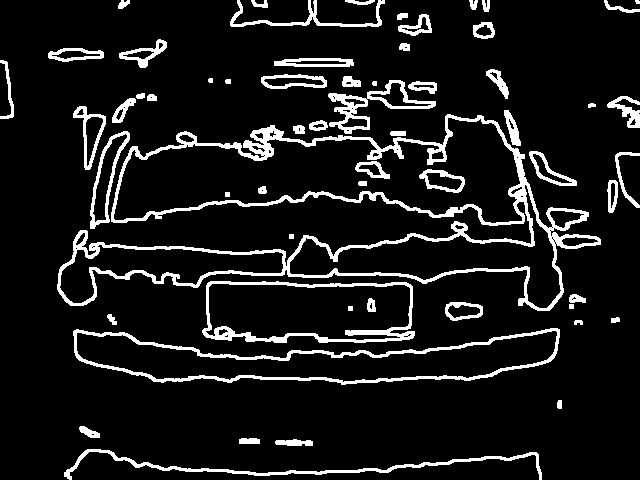

Final Output Image


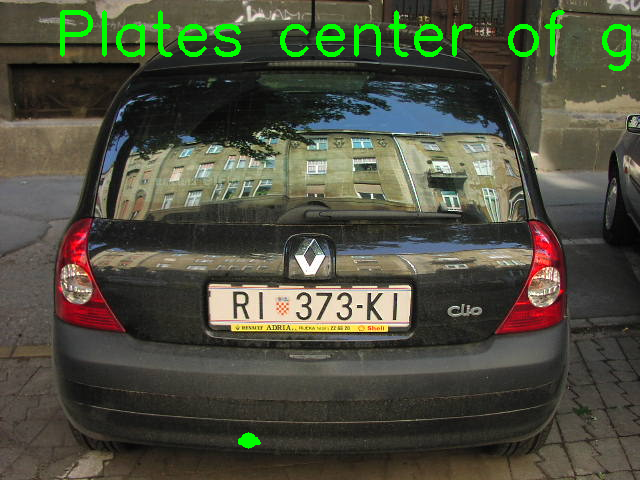

In [33]:
# Read
from google.colab.patches import cv2_imshow
imagePath = os.path.join(path_for_dataSet, '/content/ImageDataset/5.png')
initialImage = image_read(imagePath)
cv2_imshow(initialImage)

grayscaleImage = convertImg2Grayscale(initialImage)

print("Grayscale Image")
cv2_imshow(grayscaleImage)

noiseRemovedImage = remove_noise(grayscaleImage)

print("Noise Removed Image")
cv2_imshow(noiseRemovedImage)

histEqImage = equalization_histogram(noiseRemovedImage)
print("equalization_histogram")
cv2_imshow(histEqImage)

openingStructElem = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

openedImage = morphological_opening(histEqImage, openingStructElem)

subtractedImage = remove_histogram_equalization(histEqImage, openedImage)

threshImage = protect_Img(subtractedImage)

edgeDetectedImage = edge_detection(threshImage, 250, 255)

dilationStructElem = np.ones((3, 3), np.uint8)

dilatedImage = image_Edge_Dilation(edgeDetectedImage, dilationStructElem)
print("Dilated Edge Image")
cv2_imshow(dilatedImage)

contours = finding_Contours(dilatedImage)
approximatedPolygon = approx_Contors(contours)

finalImage = create_Localized_NumberPlate(initialImage, approximatedPolygon)
print("finalImage")
print(finalImage)

print("Opened Image")
cv2_imshow(openedImage)

print("Subtracted Image")
cv2_imshow(subtractedImage)

print("Thresholded Image")
cv2_imshow(threshImage)

print("Edge Detected Image")
cv2_imshow(edgeDetectedImage)

print("Dilated Edge Image")
cv2_imshow(dilatedImage)

print("Final Output Image")
cv2_imshow(initialImage)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# def DetectingNumberPlateForImages(mode, number, imageName, steps, write):
#     print("global IMAGE_LIST")
#     if(mode == "single"):
#         IMAGE_LIST = [imageName]
#     elif(mode == "multi"):
#         IMAGE_LIST = IMAGE_LIST[:number]
#     for image in IMAGE_LIST:
#         print("image in IMAGE_LIST:")
#         print(image)
#         try:
#             # Read
#             imagePath = os.path.join(path_for_dataSet, image)
#             initialImage = image_read(imagePath)
#             cv2.namedWindow("Original Image", cv2.WINDOW_NORMAL)
#             cv2.imshow("Original Image", initialImage)

#             # Convert to Grayscale
#             grayscaleImage = convertImg2Grayscale(initialImage)

#             # Noise Removal
#             noiseRemovedImage = remove_noise(grayscaleImage)

#             # Histogram Equalization
#             histEqImage = equalization_histogram(noiseRemovedImage)

#             # Structuring Element for morphological opening
#             openingStructElem = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
#             # Morphological Opening
#             openedImage = morphological_opening(histEqImage, openingStructElem)

#             # Subtract Opened Image from HistEqImage
#             subtractedImage = remove_histogram_equalization(histEqImage, openedImage)

#             # Thresholding
#             threshImage = protect_Img(subtractedImage)

#             # Canny Edge Detection
#             edgeDetectedImage = edge_detection(threshImage, 250, 255)

#             # Structuring Element for dilation
#             dilationStructElem = np.ones((3, 3), np.uint8)
#             # Dilation
#             dilatedImage = image_Edge_Dilation(edgeDetectedImage, dilationStructElem)

#             # Finding the Plate        
#             contours = finding_Contours(dilatedImage)
#             approximatedPolygon = approx_Contors(contours)
            

#             # Draw Plate Border on Original Image
#             finalImage = create_Localized_NumberPlate(initialImage, approximatedPolygon)
#             print("finalImage")
#             print(finalImage)
#             if(steps):
#                 cv2.namedWindow("Grayscale Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Grayscale Image", grayscaleImage)

#                 cv2.namedWindow("Noise Removed Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Noise Removed Image", noiseRemovedImage)

#                 cv2.namedWindow("Histogram Equalized Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Histogram Equalized Image", histEqImage)

#                 cv2.namedWindow("Opened Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Opened Image", openedImage)

#                 cv2.namedWindow("Subtracted Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Subtracted Image", subtractedImage)

#                 cv2.namedWindow("Thresholded Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Thresholded Image", threshImage)

#                 cv2.namedWindow("Edge Detected Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Edge Detected Image", edgeDetectedImage)

#                 cv2.namedWindow("Dilated Edge Image", cv2.WINDOW_NORMAL)
#                 cv2.imshow("Dilated Edge Image", dilatedImage)

#             cv2.namedWindow("Final Output Image", cv2.WINDOW_NORMAL)
#             cv2.imshow("Final Output Image", initialImage)

#             cv2.waitKey(0)
#             cv2.destroyAllWindows()

#             # Save Output Image to FinalOutput directory
#             if(write):
#                 if(steps):
#                     os.chdir(path_for_output)
#                     os.makedirs(os.path.splitext(image)[0])
#                     os.chdir('..')
#                     STEPS = os.path.join(path_for_output, os.path.splitext(image)[0])
#                     cv2.imwrite(os.path.join(STEPS, '1.png'), grayscaleImage)
#                     cv2.imwrite(os.path.join(STEPS, '2.png'), noiseRemovedImage)
#                     cv2.imwrite(os.path.join(STEPS, '3.png'), histEqImage)
#                     cv2.imwrite(os.path.join(STEPS, '4.png'), openedImage)
#                     cv2.imwrite(os.path.join(STEPS, '5.png'), subtractedImage)
#                     cv2.imwrite(os.path.join(STEPS, '6.png'), threshImage)
#                     cv2.imwrite(os.path.join(STEPS, '7.png'), edgeDetectedImage)
#                     cv2.imwrite(os.path.join(STEPS, '8.png'), dilatedImage)
#                 cv2.imwrite(os.path.join(path_for_output, os.path.splitext(image)[0] + "-detected.png"), finalImage)
#         except:
#             print("Fatal Error. Cannot Continue.")



In [ ]:
#DetectingNumberPlateForImages('single', 5, "5.png", False, False)

In [ ]:

# if __name__ == '__main__':
#     imageName = None
#     steps = False
#     write = False
#     number = 0
#     mode = "--all"
#     if("--write" in sys.argv):
#         write = True
#     if("--showsteps" in sys.argv):
#         steps = True
#     if("--single" in sys.argv):
#         mode = "single"
#         imageName = sys.argv[sys.argv.index("--single")+1]
#         if(imageName not in IMAGE_LIST):
#             print("Image not found in dataset. Exiting...")
#             sys.exit(1)
#     elif("--multi" in sys.argv):
#         mode = "multi"
#         try:
#             number = int(sys.argv[sys.argv.index("--multi")+1])
#         except:
#             print("Invalid Input for number. Use valid number or --all instead.")            
#         if(number > len(IMAGE_LIST)):
#             print("Number entered exceeds number of images in dataset. Using --all argument instead...")
#             number = len(IMAGE_LIST)


# main(mode, number, imageName, steps, write)